In [1]:
from fastai.vision import *
import os
#from efficientnet_pytorch import EfficientNet
import torchvision.models as models
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
data_path = Path('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/dataset')
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ['FASTAI_TB_CLEAR_FRAMES'] = "1"

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(42)

In [4]:
data_pave = (ImageList.from_folder(data_path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(get_transforms(),size=128)    #Data augmentation? -> use tfms with a size of 64
        .databunch(path='.', bs=128, device= torch.device('cuda:7')))       

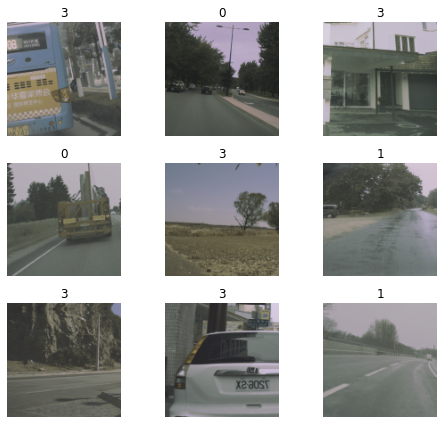

In [4]:
data_pave.show_batch(rows=3, figsize=(7,6))

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=3., reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = ((1 - pt)**self.gamma) * CE_loss
        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()

class LabelSmoothingCE(nn.Module):
    def __init__(self, eps=0.1, reduction='mean'): 
        super().__init__()
        self.eps = eps
        self.reduction = reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': 
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1) #We divide by that size at the return line so sum and not mean
            if self.reduction=='mean':  
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), reduction=self.reduction)

In [ ]:
#b0_model = EfficientNet.from_name('efficientnet-b0')
#b5_model = EfficientNet.from_pretrained('efficientnet-b5',num_classes=4)
#state_dict = torch.load('/home/jns2szh/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth')
#b0_model.load_state_dict(state_dict)
#num_ftrs = b0_model._fc.in_features
#b0_model._fc = nn.Linear(num_ftrs, 4)
#torch.backends.cudnn.benchmark = True
#resx_model = models.resnext50_32x4d(pretrained=True)
#resx_model = nn.Linear(resx_model.fc.in_features, 4)



net = models.densenet121(pretrained=True).cuda('cuda:7')
net.load_state_dict(torch.load('/home/jns2szh/.cache/torch/checkpoints/densenet121-a639ec97.pth'))

learn = Learner(data_pave, net, metrics=[accuracy, error_rate], 
                callback_fns=[ShowGraph, BnFreeze, partial(callbacks.SaveModelCallback, monitor='kappa_score', name='best_kappa')])
'''
learn =  cnn_learner(data_pave, models.densenet121, metrics=[accuracy, error_rate],
                    callback_fns=[ShowGraph, BnFreeze, partial(callbacks.SaveModelCallback, monitor='kappa_score', name='best_kappa')])
'''

In [17]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


RuntimeError: Error(s) in loading state_dict for DenseNet:
	Missing key(s) in state_dict: "features.conv0.weight", "features.norm0.weight", "features.norm0.bias", "features.norm0.running_mean", "features.norm0.running_var", "features.denseblock1.denselayer1.norm1.weight", "features.denseblock1.denselayer1.norm1.bias", "features.denseblock1.denselayer1.norm1.running_mean", "features.denseblock1.denselayer1.norm1.running_var", "features.denseblock1.denselayer1.conv1.weight", "features.denseblock1.denselayer1.norm2.weight", "features.denseblock1.denselayer1.norm2.bias", "features.denseblock1.denselayer1.norm2.running_mean", "features.denseblock1.denselayer1.norm2.running_var", "features.denseblock1.denselayer1.conv2.weight", "features.denseblock1.denselayer2.norm1.weight", "features.denseblock1.denselayer2.norm1.bias", "features.denseblock1.denselayer2.norm1.running_mean", "features.denseblock1.denselayer2.norm1.running_var", "features.denseblock1.denselayer2.conv1.weight", "features.denseblock1.denselayer2.norm2.weight", "features.denseblock1.denselayer2.norm2.bias", "features.denseblock1.denselayer2.norm2.running_mean", "features.denseblock1.denselayer2.norm2.running_var", "features.denseblock1.denselayer2.conv2.weight", "features.denseblock1.denselayer3.norm1.weight", "features.denseblock1.denselayer3.norm1.bias", "features.denseblock1.denselayer3.norm1.running_mean", "features.denseblock1.denselayer3.norm1.running_var", "features.denseblock1.denselayer3.conv1.weight", "features.denseblock1.denselayer3.norm2.weight", "features.denseblock1.denselayer3.norm2.bias", "features.denseblock1.denselayer3.norm2.running_mean", "features.denseblock1.denselayer3.norm2.running_var", "features.denseblock1.denselayer3.conv2.weight", "features.denseblock1.denselayer4.norm1.weight", "features.denseblock1.denselayer4.norm1.bias", "features.denseblock1.denselayer4.norm1.running_mean", "features.denseblock1.denselayer4.norm1.running_var", "features.denseblock1.denselayer4.conv1.weight", "features.denseblock1.denselayer4.norm2.weight", "features.denseblock1.denselayer4.norm2.bias", "features.denseblock1.denselayer4.norm2.running_mean", "features.denseblock1.denselayer4.norm2.running_var", "features.denseblock1.denselayer4.conv2.weight", "features.denseblock1.denselayer5.norm1.weight", "features.denseblock1.denselayer5.norm1.bias", "features.denseblock1.denselayer5.norm1.running_mean", "features.denseblock1.denselayer5.norm1.running_var", "features.denseblock1.denselayer5.conv1.weight", "features.denseblock1.denselayer5.norm2.weight", "features.denseblock1.denselayer5.norm2.bias", "features.denseblock1.denselayer5.norm2.running_mean", "features.denseblock1.denselayer5.norm2.running_var", "features.denseblock1.denselayer5.conv2.weight", "features.denseblock1.denselayer6.norm1.weight", "features.denseblock1.denselayer6.norm1.bias", "features.denseblock1.denselayer6.norm1.running_mean", "features.denseblock1.denselayer6.norm1.running_var", "features.denseblock1.denselayer6.conv1.weight", "features.denseblock1.denselayer6.norm2.weight", "features.denseblock1.denselayer6.norm2.bias", "features.denseblock1.denselayer6.norm2.running_mean", "features.denseblock1.denselayer6.norm2.running_var", "features.denseblock1.denselayer6.conv2.weight", "features.transition1.norm.weight", "features.transition1.norm.bias", "features.transition1.norm.running_mean", "features.transition1.norm.running_var", "features.transition1.conv.weight", "features.denseblock2.denselayer1.norm1.weight", "features.denseblock2.denselayer1.norm1.bias", "features.denseblock2.denselayer1.norm1.running_mean", "features.denseblock2.denselayer1.norm1.running_var", "features.denseblock2.denselayer1.conv1.weight", "features.denseblock2.denselayer1.norm2.weight", "features.denseblock2.denselayer1.norm2.bias", "features.denseblock2.denselayer1.norm2.running_mean", "features.denseblock2.denselayer1.norm2.running_var", "features.denseblock2.denselayer1.conv2.weight", "features.denseblock2.denselayer2.norm1.weight", "features.denseblock2.denselayer2.norm1.bias", "features.denseblock2.denselayer2.norm1.running_mean", "features.denseblock2.denselayer2.norm1.running_var", "features.denseblock2.denselayer2.conv1.weight", "features.denseblock2.denselayer2.norm2.weight", "features.denseblock2.denselayer2.norm2.bias", "features.denseblock2.denselayer2.norm2.running_mean", "features.denseblock2.denselayer2.norm2.running_var", "features.denseblock2.denselayer2.conv2.weight", "features.denseblock2.denselayer3.norm1.weight", "features.denseblock2.denselayer3.norm1.bias", "features.denseblock2.denselayer3.norm1.running_mean", "features.denseblock2.denselayer3.norm1.running_var", "features.denseblock2.denselayer3.conv1.weight", "features.denseblock2.denselayer3.norm2.weight", "features.denseblock2.denselayer3.norm2.bias", "features.denseblock2.denselayer3.norm2.running_mean", "features.denseblock2.denselayer3.norm2.running_var", "features.denseblock2.denselayer3.conv2.weight", "features.denseblock2.denselayer4.norm1.weight", "features.denseblock2.denselayer4.norm1.bias", "features.denseblock2.denselayer4.norm1.running_mean", "features.denseblock2.denselayer4.norm1.running_var", "features.denseblock2.denselayer4.conv1.weight", "features.denseblock2.denselayer4.norm2.weight", "features.denseblock2.denselayer4.norm2.bias", "features.denseblock2.denselayer4.norm2.running_mean", "features.denseblock2.denselayer4.norm2.running_var", "features.denseblock2.denselayer4.conv2.weight", "features.denseblock2.denselayer5.norm1.weight", "features.denseblock2.denselayer5.norm1.bias", "features.denseblock2.denselayer5.norm1.running_mean", "features.denseblock2.denselayer5.norm1.running_var", "features.denseblock2.denselayer5.conv1.weight", "features.denseblock2.denselayer5.norm2.weight", "features.denseblock2.denselayer5.norm2.bias", "features.denseblock2.denselayer5.norm2.running_mean", "features.denseblock2.denselayer5.norm2.running_var", "features.denseblock2.denselayer5.conv2.weight", "features.denseblock2.denselayer6.norm1.weight", "features.denseblock2.denselayer6.norm1.bias", "features.denseblock2.denselayer6.norm1.running_mean", "features.denseblock2.denselayer6.norm1.running_var", "features.denseblock2.denselayer6.conv1.weight", "features.denseblock2.denselayer6.norm2.weight", "features.denseblock2.denselayer6.norm2.bias", "features.denseblock2.denselayer6.norm2.running_mean", "features.denseblock2.denselayer6.norm2.running_var", "features.denseblock2.denselayer6.conv2.weight", "features.denseblock2.denselayer7.norm1.weight", "features.denseblock2.denselayer7.norm1.bias", "features.denseblock2.denselayer7.norm1.running_mean", "features.denseblock2.denselayer7.norm1.running_var", "features.denseblock2.denselayer7.conv1.weight", "features.denseblock2.denselayer7.norm2.weight", "features.denseblock2.denselayer7.norm2.bias", "features.denseblock2.denselayer7.norm2.running_mean", "features.denseblock2.denselayer7.norm2.running_var", "features.denseblock2.denselayer7.conv2.weight", "features.denseblock2.denselayer8.norm1.weight", "features.denseblock2.denselayer8.norm1.bias", "features.denseblock2.denselayer8.norm1.running_mean", "features.denseblock2.denselayer8.norm1.running_var", "features.denseblock2.denselayer8.conv1.weight", "features.denseblock2.denselayer8.norm2.weight", "features.denseblock2.denselayer8.norm2.bias", "features.denseblock2.denselayer8.norm2.running_mean", "features.denseblock2.denselayer8.norm2.running_var", "features.denseblock2.denselayer8.conv2.weight", "features.denseblock2.denselayer9.norm1.weight", "features.denseblock2.denselayer9.norm1.bias", "features.denseblock2.denselayer9.norm1.running_mean", "features.denseblock2.denselayer9.norm1.running_var", "features.denseblock2.denselayer9.conv1.weight", "features.denseblock2.denselayer9.norm2.weight", "features.denseblock2.denselayer9.norm2.bias", "features.denseblock2.denselayer9.norm2.running_mean", "features.denseblock2.denselayer9.norm2.running_var", "features.denseblock2.denselayer9.conv2.weight", "features.denseblock2.denselayer10.norm1.weight", "features.denseblock2.denselayer10.norm1.bias", "features.denseblock2.denselayer10.norm1.running_mean", "features.denseblock2.denselayer10.norm1.running_var", "features.denseblock2.denselayer10.conv1.weight", "features.denseblock2.denselayer10.norm2.weight", "features.denseblock2.denselayer10.norm2.bias", "features.denseblock2.denselayer10.norm2.running_mean", "features.denseblock2.denselayer10.norm2.running_var", "features.denseblock2.denselayer10.conv2.weight", "features.denseblock2.denselayer11.norm1.weight", "features.denseblock2.denselayer11.norm1.bias", "features.denseblock2.denselayer11.norm1.running_mean", "features.denseblock2.denselayer11.norm1.running_var", "features.denseblock2.denselayer11.conv1.weight", "features.denseblock2.denselayer11.norm2.weight", "features.denseblock2.denselayer11.norm2.bias", "features.denseblock2.denselayer11.norm2.running_mean", "features.denseblock2.denselayer11.norm2.running_var", "features.denseblock2.denselayer11.conv2.weight", "features.denseblock2.denselayer12.norm1.weight", "features.denseblock2.denselayer12.norm1.bias", "features.denseblock2.denselayer12.norm1.running_mean", "features.denseblock2.denselayer12.norm1.running_var", "features.denseblock2.denselayer12.conv1.weight", "features.denseblock2.denselayer12.norm2.weight", "features.denseblock2.denselayer12.norm2.bias", "features.denseblock2.denselayer12.norm2.running_mean", "features.denseblock2.denselayer12.norm2.running_var", "features.denseblock2.denselayer12.conv2.weight", "features.transition2.norm.weight", "features.transition2.norm.bias", "features.transition2.norm.running_mean", "features.transition2.norm.running_var", "features.transition2.conv.weight", "features.denseblock3.denselayer1.norm1.weight", "features.denseblock3.denselayer1.norm1.bias", "features.denseblock3.denselayer1.norm1.running_mean", "features.denseblock3.denselayer1.norm1.running_var", "features.denseblock3.denselayer1.conv1.weight", "features.denseblock3.denselayer1.norm2.weight", "features.denseblock3.denselayer1.norm2.bias", "features.denseblock3.denselayer1.norm2.running_mean", "features.denseblock3.denselayer1.norm2.running_var", "features.denseblock3.denselayer1.conv2.weight", "features.denseblock3.denselayer2.norm1.weight", "features.denseblock3.denselayer2.norm1.bias", "features.denseblock3.denselayer2.norm1.running_mean", "features.denseblock3.denselayer2.norm1.running_var", "features.denseblock3.denselayer2.conv1.weight", "features.denseblock3.denselayer2.norm2.weight", "features.denseblock3.denselayer2.norm2.bias", "features.denseblock3.denselayer2.norm2.running_mean", "features.denseblock3.denselayer2.norm2.running_var", "features.denseblock3.denselayer2.conv2.weight", "features.denseblock3.denselayer3.norm1.weight", "features.denseblock3.denselayer3.norm1.bias", "features.denseblock3.denselayer3.norm1.running_mean", "features.denseblock3.denselayer3.norm1.running_var", "features.denseblock3.denselayer3.conv1.weight", "features.denseblock3.denselayer3.norm2.weight", "features.denseblock3.denselayer3.norm2.bias", "features.denseblock3.denselayer3.norm2.running_mean", "features.denseblock3.denselayer3.norm2.running_var", "features.denseblock3.denselayer3.conv2.weight", "features.denseblock3.denselayer4.norm1.weight", "features.denseblock3.denselayer4.norm1.bias", "features.denseblock3.denselayer4.norm1.running_mean", "features.denseblock3.denselayer4.norm1.running_var", "features.denseblock3.denselayer4.conv1.weight", "features.denseblock3.denselayer4.norm2.weight", "features.denseblock3.denselayer4.norm2.bias", "features.denseblock3.denselayer4.norm2.running_mean", "features.denseblock3.denselayer4.norm2.running_var", "features.denseblock3.denselayer4.conv2.weight", "features.denseblock3.denselayer5.norm1.weight", "features.denseblock3.denselayer5.norm1.bias", "features.denseblock3.denselayer5.norm1.running_mean", "features.denseblock3.denselayer5.norm1.running_var", "features.denseblock3.denselayer5.conv1.weight", "features.denseblock3.denselayer5.norm2.weight", "features.denseblock3.denselayer5.norm2.bias", "features.denseblock3.denselayer5.norm2.running_mean", "features.denseblock3.denselayer5.norm2.running_var", "features.denseblock3.denselayer5.conv2.weight", "features.denseblock3.denselayer6.norm1.weight", "features.denseblock3.denselayer6.norm1.bias", "features.denseblock3.denselayer6.norm1.running_mean", "features.denseblock3.denselayer6.norm1.running_var", "features.denseblock3.denselayer6.conv1.weight", "features.denseblock3.denselayer6.norm2.weight", "features.denseblock3.denselayer6.norm2.bias", "features.denseblock3.denselayer6.norm2.running_mean", "features.denseblock3.denselayer6.norm2.running_var", "features.denseblock3.denselayer6.conv2.weight", "features.denseblock3.denselayer7.norm1.weight", "features.denseblock3.denselayer7.norm1.bias", "features.denseblock3.denselayer7.norm1.running_mean", "features.denseblock3.denselayer7.norm1.running_var", "features.denseblock3.denselayer7.conv1.weight", "features.denseblock3.denselayer7.norm2.weight", "features.denseblock3.denselayer7.norm2.bias", "features.denseblock3.denselayer7.norm2.running_mean", "features.denseblock3.denselayer7.norm2.running_var", "features.denseblock3.denselayer7.conv2.weight", "features.denseblock3.denselayer8.norm1.weight", "features.denseblock3.denselayer8.norm1.bias", "features.denseblock3.denselayer8.norm1.running_mean", "features.denseblock3.denselayer8.norm1.running_var", "features.denseblock3.denselayer8.conv1.weight", "features.denseblock3.denselayer8.norm2.weight", "features.denseblock3.denselayer8.norm2.bias", "features.denseblock3.denselayer8.norm2.running_mean", "features.denseblock3.denselayer8.norm2.running_var", "features.denseblock3.denselayer8.conv2.weight", "features.denseblock3.denselayer9.norm1.weight", "features.denseblock3.denselayer9.norm1.bias", "features.denseblock3.denselayer9.norm1.running_mean", "features.denseblock3.denselayer9.norm1.running_var", "features.denseblock3.denselayer9.conv1.weight", "features.denseblock3.denselayer9.norm2.weight", "features.denseblock3.denselayer9.norm2.bias", "features.denseblock3.denselayer9.norm2.running_mean", "features.denseblock3.denselayer9.norm2.running_var", "features.denseblock3.denselayer9.conv2.weight", "features.denseblock3.denselayer10.norm1.weight", "features.denseblock3.denselayer10.norm1.bias", "features.denseblock3.denselayer10.norm1.running_mean", "features.denseblock3.denselayer10.norm1.running_var", "features.denseblock3.denselayer10.conv1.weight", "features.denseblock3.denselayer10.norm2.weight", "features.denseblock3.denselayer10.norm2.bias", "features.denseblock3.denselayer10.norm2.running_mean", "features.denseblock3.denselayer10.norm2.running_var", "features.denseblock3.denselayer10.conv2.weight", "features.denseblock3.denselayer11.norm1.weight", "features.denseblock3.denselayer11.norm1.bias", "features.denseblock3.denselayer11.norm1.running_mean", "features.denseblock3.denselayer11.norm1.running_var", "features.denseblock3.denselayer11.conv1.weight", "features.denseblock3.denselayer11.norm2.weight", "features.denseblock3.denselayer11.norm2.bias", "features.denseblock3.denselayer11.norm2.running_mean", "features.denseblock3.denselayer11.norm2.running_var", "features.denseblock3.denselayer11.conv2.weight", "features.denseblock3.denselayer12.norm1.weight", "features.denseblock3.denselayer12.norm1.bias", "features.denseblock3.denselayer12.norm1.running_mean", "features.denseblock3.denselayer12.norm1.running_var", "features.denseblock3.denselayer12.conv1.weight", "features.denseblock3.denselayer12.norm2.weight", "features.denseblock3.denselayer12.norm2.bias", "features.denseblock3.denselayer12.norm2.running_mean", "features.denseblock3.denselayer12.norm2.running_var", "features.denseblock3.denselayer12.conv2.weight", "features.denseblock3.denselayer13.norm1.weight", "features.denseblock3.denselayer13.norm1.bias", "features.denseblock3.denselayer13.norm1.running_mean", "features.denseblock3.denselayer13.norm1.running_var", "features.denseblock3.denselayer13.conv1.weight", "features.denseblock3.denselayer13.norm2.weight", "features.denseblock3.denselayer13.norm2.bias", "features.denseblock3.denselayer13.norm2.running_mean", "features.denseblock3.denselayer13.norm2.running_var", "features.denseblock3.denselayer13.conv2.weight", "features.denseblock3.denselayer14.norm1.weight", "features.denseblock3.denselayer14.norm1.bias", "features.denseblock3.denselayer14.norm1.running_mean", "features.denseblock3.denselayer14.norm1.running_var", "features.denseblock3.denselayer14.conv1.weight", "features.denseblock3.denselayer14.norm2.weight", "features.denseblock3.denselayer14.norm2.bias", "features.denseblock3.denselayer14.norm2.running_mean", "features.denseblock3.denselayer14.norm2.running_var", "features.denseblock3.denselayer14.conv2.weight", "features.denseblock3.denselayer15.norm1.weight", "features.denseblock3.denselayer15.norm1.bias", "features.denseblock3.denselayer15.norm1.running_mean", "features.denseblock3.denselayer15.norm1.running_var", "features.denseblock3.denselayer15.conv1.weight", "features.denseblock3.denselayer15.norm2.weight", "features.denseblock3.denselayer15.norm2.bias", "features.denseblock3.denselayer15.norm2.running_mean", "features.denseblock3.denselayer15.norm2.running_var", "features.denseblock3.denselayer15.conv2.weight", "features.denseblock3.denselayer16.norm1.weight", "features.denseblock3.denselayer16.norm1.bias", "features.denseblock3.denselayer16.norm1.running_mean", "features.denseblock3.denselayer16.norm1.running_var", "features.denseblock3.denselayer16.conv1.weight", "features.denseblock3.denselayer16.norm2.weight", "features.denseblock3.denselayer16.norm2.bias", "features.denseblock3.denselayer16.norm2.running_mean", "features.denseblock3.denselayer16.norm2.running_var", "features.denseblock3.denselayer16.conv2.weight", "features.denseblock3.denselayer17.norm1.weight", "features.denseblock3.denselayer17.norm1.bias", "features.denseblock3.denselayer17.norm1.running_mean", "features.denseblock3.denselayer17.norm1.running_var", "features.denseblock3.denselayer17.conv1.weight", "features.denseblock3.denselayer17.norm2.weight", "features.denseblock3.denselayer17.norm2.bias", "features.denseblock3.denselayer17.norm2.running_mean", "features.denseblock3.denselayer17.norm2.running_var", "features.denseblock3.denselayer17.conv2.weight", "features.denseblock3.denselayer18.norm1.weight", "features.denseblock3.denselayer18.norm1.bias", "features.denseblock3.denselayer18.norm1.running_mean", "features.denseblock3.denselayer18.norm1.running_var", "features.denseblock3.denselayer18.conv1.weight", "features.denseblock3.denselayer18.norm2.weight", "features.denseblock3.denselayer18.norm2.bias", "features.denseblock3.denselayer18.norm2.running_mean", "features.denseblock3.denselayer18.norm2.running_var", "features.denseblock3.denselayer18.conv2.weight", "features.denseblock3.denselayer19.norm1.weight", "features.denseblock3.denselayer19.norm1.bias", "features.denseblock3.denselayer19.norm1.running_mean", "features.denseblock3.denselayer19.norm1.running_var", "features.denseblock3.denselayer19.conv1.weight", "features.denseblock3.denselayer19.norm2.weight", "features.denseblock3.denselayer19.norm2.bias", "features.denseblock3.denselayer19.norm2.running_mean", "features.denseblock3.denselayer19.norm2.running_var", "features.denseblock3.denselayer19.conv2.weight", "features.denseblock3.denselayer20.norm1.weight", "features.denseblock3.denselayer20.norm1.bias", "features.denseblock3.denselayer20.norm1.running_mean", "features.denseblock3.denselayer20.norm1.running_var", "features.denseblock3.denselayer20.conv1.weight", "features.denseblock3.denselayer20.norm2.weight", "features.denseblock3.denselayer20.norm2.bias", "features.denseblock3.denselayer20.norm2.running_mean", "features.denseblock3.denselayer20.norm2.running_var", "features.denseblock3.denselayer20.conv2.weight", "features.denseblock3.denselayer21.norm1.weight", "features.denseblock3.denselayer21.norm1.bias", "features.denseblock3.denselayer21.norm1.running_mean", "features.denseblock3.denselayer21.norm1.running_var", "features.denseblock3.denselayer21.conv1.weight", "features.denseblock3.denselayer21.norm2.weight", "features.denseblock3.denselayer21.norm2.bias", "features.denseblock3.denselayer21.norm2.running_mean", "features.denseblock3.denselayer21.norm2.running_var", "features.denseblock3.denselayer21.conv2.weight", "features.denseblock3.denselayer22.norm1.weight", "features.denseblock3.denselayer22.norm1.bias", "features.denseblock3.denselayer22.norm1.running_mean", "features.denseblock3.denselayer22.norm1.running_var", "features.denseblock3.denselayer22.conv1.weight", "features.denseblock3.denselayer22.norm2.weight", "features.denseblock3.denselayer22.norm2.bias", "features.denseblock3.denselayer22.norm2.running_mean", "features.denseblock3.denselayer22.norm2.running_var", "features.denseblock3.denselayer22.conv2.weight", "features.denseblock3.denselayer23.norm1.weight", "features.denseblock3.denselayer23.norm1.bias", "features.denseblock3.denselayer23.norm1.running_mean", "features.denseblock3.denselayer23.norm1.running_var", "features.denseblock3.denselayer23.conv1.weight", "features.denseblock3.denselayer23.norm2.weight", "features.denseblock3.denselayer23.norm2.bias", "features.denseblock3.denselayer23.norm2.running_mean", "features.denseblock3.denselayer23.norm2.running_var", "features.denseblock3.denselayer23.conv2.weight", "features.denseblock3.denselayer24.norm1.weight", "features.denseblock3.denselayer24.norm1.bias", "features.denseblock3.denselayer24.norm1.running_mean", "features.denseblock3.denselayer24.norm1.running_var", "features.denseblock3.denselayer24.conv1.weight", "features.denseblock3.denselayer24.norm2.weight", "features.denseblock3.denselayer24.norm2.bias", "features.denseblock3.denselayer24.norm2.running_mean", "features.denseblock3.denselayer24.norm2.running_var", "features.denseblock3.denselayer24.conv2.weight", "features.transition3.norm.weight", "features.transition3.norm.bias", "features.transition3.norm.running_mean", "features.transition3.norm.running_var", "features.transition3.conv.weight", "features.denseblock4.denselayer1.norm1.weight", "features.denseblock4.denselayer1.norm1.bias", "features.denseblock4.denselayer1.norm1.running_mean", "features.denseblock4.denselayer1.norm1.running_var", "features.denseblock4.denselayer1.conv1.weight", "features.denseblock4.denselayer1.norm2.weight", "features.denseblock4.denselayer1.norm2.bias", "features.denseblock4.denselayer1.norm2.running_mean", "features.denseblock4.denselayer1.norm2.running_var", "features.denseblock4.denselayer1.conv2.weight", "features.denseblock4.denselayer2.norm1.weight", "features.denseblock4.denselayer2.norm1.bias", "features.denseblock4.denselayer2.norm1.running_mean", "features.denseblock4.denselayer2.norm1.running_var", "features.denseblock4.denselayer2.conv1.weight", "features.denseblock4.denselayer2.norm2.weight", "features.denseblock4.denselayer2.norm2.bias", "features.denseblock4.denselayer2.norm2.running_mean", "features.denseblock4.denselayer2.norm2.running_var", "features.denseblock4.denselayer2.conv2.weight", "features.denseblock4.denselayer3.norm1.weight", "features.denseblock4.denselayer3.norm1.bias", "features.denseblock4.denselayer3.norm1.running_mean", "features.denseblock4.denselayer3.norm1.running_var", "features.denseblock4.denselayer3.conv1.weight", "features.denseblock4.denselayer3.norm2.weight", "features.denseblock4.denselayer3.norm2.bias", "features.denseblock4.denselayer3.norm2.running_mean", "features.denseblock4.denselayer3.norm2.running_var", "features.denseblock4.denselayer3.conv2.weight", "features.denseblock4.denselayer4.norm1.weight", "features.denseblock4.denselayer4.norm1.bias", "features.denseblock4.denselayer4.norm1.running_mean", "features.denseblock4.denselayer4.norm1.running_var", "features.denseblock4.denselayer4.conv1.weight", "features.denseblock4.denselayer4.norm2.weight", "features.denseblock4.denselayer4.norm2.bias", "features.denseblock4.denselayer4.norm2.running_mean", "features.denseblock4.denselayer4.norm2.running_var", "features.denseblock4.denselayer4.conv2.weight", "features.denseblock4.denselayer5.norm1.weight", "features.denseblock4.denselayer5.norm1.bias", "features.denseblock4.denselayer5.norm1.running_mean", "features.denseblock4.denselayer5.norm1.running_var", "features.denseblock4.denselayer5.conv1.weight", "features.denseblock4.denselayer5.norm2.weight", "features.denseblock4.denselayer5.norm2.bias", "features.denseblock4.denselayer5.norm2.running_mean", "features.denseblock4.denselayer5.norm2.running_var", "features.denseblock4.denselayer5.conv2.weight", "features.denseblock4.denselayer6.norm1.weight", "features.denseblock4.denselayer6.norm1.bias", "features.denseblock4.denselayer6.norm1.running_mean", "features.denseblock4.denselayer6.norm1.running_var", "features.denseblock4.denselayer6.conv1.weight", "features.denseblock4.denselayer6.norm2.weight", "features.denseblock4.denselayer6.norm2.bias", "features.denseblock4.denselayer6.norm2.running_mean", "features.denseblock4.denselayer6.norm2.running_var", "features.denseblock4.denselayer6.conv2.weight", "features.denseblock4.denselayer7.norm1.weight", "features.denseblock4.denselayer7.norm1.bias", "features.denseblock4.denselayer7.norm1.running_mean", "features.denseblock4.denselayer7.norm1.running_var", "features.denseblock4.denselayer7.conv1.weight", "features.denseblock4.denselayer7.norm2.weight", "features.denseblock4.denselayer7.norm2.bias", "features.denseblock4.denselayer7.norm2.running_mean", "features.denseblock4.denselayer7.norm2.running_var", "features.denseblock4.denselayer7.conv2.weight", "features.denseblock4.denselayer8.norm1.weight", "features.denseblock4.denselayer8.norm1.bias", "features.denseblock4.denselayer8.norm1.running_mean", "features.denseblock4.denselayer8.norm1.running_var", "features.denseblock4.denselayer8.conv1.weight", "features.denseblock4.denselayer8.norm2.weight", "features.denseblock4.denselayer8.norm2.bias", "features.denseblock4.denselayer8.norm2.running_mean", "features.denseblock4.denselayer8.norm2.running_var", "features.denseblock4.denselayer8.conv2.weight", "features.denseblock4.denselayer9.norm1.weight", "features.denseblock4.denselayer9.norm1.bias", "features.denseblock4.denselayer9.norm1.running_mean", "features.denseblock4.denselayer9.norm1.running_var", "features.denseblock4.denselayer9.conv1.weight", "features.denseblock4.denselayer9.norm2.weight", "features.denseblock4.denselayer9.norm2.bias", "features.denseblock4.denselayer9.norm2.running_mean", "features.denseblock4.denselayer9.norm2.running_var", "features.denseblock4.denselayer9.conv2.weight", "features.denseblock4.denselayer10.norm1.weight", "features.denseblock4.denselayer10.norm1.bias", "features.denseblock4.denselayer10.norm1.running_mean", "features.denseblock4.denselayer10.norm1.running_var", "features.denseblock4.denselayer10.conv1.weight", "features.denseblock4.denselayer10.norm2.weight", "features.denseblock4.denselayer10.norm2.bias", "features.denseblock4.denselayer10.norm2.running_mean", "features.denseblock4.denselayer10.norm2.running_var", "features.denseblock4.denselayer10.conv2.weight", "features.denseblock4.denselayer11.norm1.weight", "features.denseblock4.denselayer11.norm1.bias", "features.denseblock4.denselayer11.norm1.running_mean", "features.denseblock4.denselayer11.norm1.running_var", "features.denseblock4.denselayer11.conv1.weight", "features.denseblock4.denselayer11.norm2.weight", "features.denseblock4.denselayer11.norm2.bias", "features.denseblock4.denselayer11.norm2.running_mean", "features.denseblock4.denselayer11.norm2.running_var", "features.denseblock4.denselayer11.conv2.weight", "features.denseblock4.denselayer12.norm1.weight", "features.denseblock4.denselayer12.norm1.bias", "features.denseblock4.denselayer12.norm1.running_mean", "features.denseblock4.denselayer12.norm1.running_var", "features.denseblock4.denselayer12.conv1.weight", "features.denseblock4.denselayer12.norm2.weight", "features.denseblock4.denselayer12.norm2.bias", "features.denseblock4.denselayer12.norm2.running_mean", "features.denseblock4.denselayer12.norm2.running_var", "features.denseblock4.denselayer12.conv2.weight", "features.denseblock4.denselayer13.norm1.weight", "features.denseblock4.denselayer13.norm1.bias", "features.denseblock4.denselayer13.norm1.running_mean", "features.denseblock4.denselayer13.norm1.running_var", "features.denseblock4.denselayer13.conv1.weight", "features.denseblock4.denselayer13.norm2.weight", "features.denseblock4.denselayer13.norm2.bias", "features.denseblock4.denselayer13.norm2.running_mean", "features.denseblock4.denselayer13.norm2.running_var", "features.denseblock4.denselayer13.conv2.weight", "features.denseblock4.denselayer14.norm1.weight", "features.denseblock4.denselayer14.norm1.bias", "features.denseblock4.denselayer14.norm1.running_mean", "features.denseblock4.denselayer14.norm1.running_var", "features.denseblock4.denselayer14.conv1.weight", "features.denseblock4.denselayer14.norm2.weight", "features.denseblock4.denselayer14.norm2.bias", "features.denseblock4.denselayer14.norm2.running_mean", "features.denseblock4.denselayer14.norm2.running_var", "features.denseblock4.denselayer14.conv2.weight", "features.denseblock4.denselayer15.norm1.weight", "features.denseblock4.denselayer15.norm1.bias", "features.denseblock4.denselayer15.norm1.running_mean", "features.denseblock4.denselayer15.norm1.running_var", "features.denseblock4.denselayer15.conv1.weight", "features.denseblock4.denselayer15.norm2.weight", "features.denseblock4.denselayer15.norm2.bias", "features.denseblock4.denselayer15.norm2.running_mean", "features.denseblock4.denselayer15.norm2.running_var", "features.denseblock4.denselayer15.conv2.weight", "features.denseblock4.denselayer16.norm1.weight", "features.denseblock4.denselayer16.norm1.bias", "features.denseblock4.denselayer16.norm1.running_mean", "features.denseblock4.denselayer16.norm1.running_var", "features.denseblock4.denselayer16.conv1.weight", "features.denseblock4.denselayer16.norm2.weight", "features.denseblock4.denselayer16.norm2.bias", "features.denseblock4.denselayer16.norm2.running_mean", "features.denseblock4.denselayer16.norm2.running_var", "features.denseblock4.denselayer16.conv2.weight", "features.norm5.weight", "features.norm5.bias", "features.norm5.running_mean", "features.norm5.running_var", "classifier.weight", "classifier.bias". 
	Unexpected key(s) in state_dict: "_conv_stem.weight", "_bn0.weight", "_bn0.bias", "_bn0.running_mean", "_bn0.running_var", "_bn0.num_batches_tracked", "_blocks.0._depthwise_conv.weight", "_blocks.0._bn1.weight", "_blocks.0._bn1.bias", "_blocks.0._bn1.running_mean", "_blocks.0._bn1.running_var", "_blocks.0._bn1.num_batches_tracked", "_blocks.0._se_reduce.weight", "_blocks.0._se_reduce.bias", "_blocks.0._se_expand.weight", "_blocks.0._se_expand.bias", "_blocks.0._project_conv.weight", "_blocks.0._bn2.weight", "_blocks.0._bn2.bias", "_blocks.0._bn2.running_mean", "_blocks.0._bn2.running_var", "_blocks.0._bn2.num_batches_tracked", "_blocks.1._depthwise_conv.weight", "_blocks.1._bn1.weight", "_blocks.1._bn1.bias", "_blocks.1._bn1.running_mean", "_blocks.1._bn1.running_var", "_blocks.1._bn1.num_batches_tracked", "_blocks.1._se_reduce.weight", "_blocks.1._se_reduce.bias", "_blocks.1._se_expand.weight", "_blocks.1._se_expand.bias", "_blocks.1._project_conv.weight", "_blocks.1._bn2.weight", "_blocks.1._bn2.bias", "_blocks.1._bn2.running_mean", "_blocks.1._bn2.running_var", "_blocks.1._bn2.num_batches_tracked", "_blocks.2._expand_conv.weight", "_blocks.2._bn0.weight", "_blocks.2._bn0.bias", "_blocks.2._bn0.running_mean", "_blocks.2._bn0.running_var", "_blocks.2._bn0.num_batches_tracked", "_blocks.2._depthwise_conv.weight", "_blocks.2._bn1.weight", "_blocks.2._bn1.bias", "_blocks.2._bn1.running_mean", "_blocks.2._bn1.running_var", "_blocks.2._bn1.num_batches_tracked", "_blocks.2._se_reduce.weight", "_blocks.2._se_reduce.bias", "_blocks.2._se_expand.weight", "_blocks.2._se_expand.bias", "_blocks.2._project_conv.weight", "_blocks.2._bn2.weight", "_blocks.2._bn2.bias", "_blocks.2._bn2.running_mean", "_blocks.2._bn2.running_var", "_blocks.2._bn2.num_batches_tracked", "_blocks.3._expand_conv.weight", "_blocks.3._bn0.weight", "_blocks.3._bn0.bias", "_blocks.3._bn0.running_mean", "_blocks.3._bn0.running_var", "_blocks.3._bn0.num_batches_tracked", "_blocks.3._depthwise_conv.weight", "_blocks.3._bn1.weight", "_blocks.3._bn1.bias", "_blocks.3._bn1.running_mean", "_blocks.3._bn1.running_var", "_blocks.3._bn1.num_batches_tracked", "_blocks.3._se_reduce.weight", "_blocks.3._se_reduce.bias", "_blocks.3._se_expand.weight", "_blocks.3._se_expand.bias", "_blocks.3._project_conv.weight", "_blocks.3._bn2.weight", "_blocks.3._bn2.bias", "_blocks.3._bn2.running_mean", "_blocks.3._bn2.running_var", "_blocks.3._bn2.num_batches_tracked", "_blocks.4._expand_conv.weight", "_blocks.4._bn0.weight", "_blocks.4._bn0.bias", "_blocks.4._bn0.running_mean", "_blocks.4._bn0.running_var", "_blocks.4._bn0.num_batches_tracked", "_blocks.4._depthwise_conv.weight", "_blocks.4._bn1.weight", "_blocks.4._bn1.bias", "_blocks.4._bn1.running_mean", "_blocks.4._bn1.running_var", "_blocks.4._bn1.num_batches_tracked", "_blocks.4._se_reduce.weight", "_blocks.4._se_reduce.bias", "_blocks.4._se_expand.weight", "_blocks.4._se_expand.bias", "_blocks.4._project_conv.weight", "_blocks.4._bn2.weight", "_blocks.4._bn2.bias", "_blocks.4._bn2.running_mean", "_blocks.4._bn2.running_var", "_blocks.4._bn2.num_batches_tracked", "_blocks.5._expand_conv.weight", "_blocks.5._bn0.weight", "_blocks.5._bn0.bias", "_blocks.5._bn0.running_mean", "_blocks.5._bn0.running_var", "_blocks.5._bn0.num_batches_tracked", "_blocks.5._depthwise_conv.weight", "_blocks.5._bn1.weight", "_blocks.5._bn1.bias", "_blocks.5._bn1.running_mean", "_blocks.5._bn1.running_var", "_blocks.5._bn1.num_batches_tracked", "_blocks.5._se_reduce.weight", "_blocks.5._se_reduce.bias", "_blocks.5._se_expand.weight", "_blocks.5._se_expand.bias", "_blocks.5._project_conv.weight", "_blocks.5._bn2.weight", "_blocks.5._bn2.bias", "_blocks.5._bn2.running_mean", "_blocks.5._bn2.running_var", "_blocks.5._bn2.num_batches_tracked", "_blocks.6._expand_conv.weight", "_blocks.6._bn0.weight", "_blocks.6._bn0.bias", "_blocks.6._bn0.running_mean", "_blocks.6._bn0.running_var", "_blocks.6._bn0.num_batches_tracked", "_blocks.6._depthwise_conv.weight", "_blocks.6._bn1.weight", "_blocks.6._bn1.bias", "_blocks.6._bn1.running_mean", "_blocks.6._bn1.running_var", "_blocks.6._bn1.num_batches_tracked", "_blocks.6._se_reduce.weight", "_blocks.6._se_reduce.bias", "_blocks.6._se_expand.weight", "_blocks.6._se_expand.bias", "_blocks.6._project_conv.weight", "_blocks.6._bn2.weight", "_blocks.6._bn2.bias", "_blocks.6._bn2.running_mean", "_blocks.6._bn2.running_var", "_blocks.6._bn2.num_batches_tracked", "_blocks.7._expand_conv.weight", "_blocks.7._bn0.weight", "_blocks.7._bn0.bias", "_blocks.7._bn0.running_mean", "_blocks.7._bn0.running_var", "_blocks.7._bn0.num_batches_tracked", "_blocks.7._depthwise_conv.weight", "_blocks.7._bn1.weight", "_blocks.7._bn1.bias", "_blocks.7._bn1.running_mean", "_blocks.7._bn1.running_var", "_blocks.7._bn1.num_batches_tracked", "_blocks.7._se_reduce.weight", "_blocks.7._se_reduce.bias", "_blocks.7._se_expand.weight", "_blocks.7._se_expand.bias", "_blocks.7._project_conv.weight", "_blocks.7._bn2.weight", "_blocks.7._bn2.bias", "_blocks.7._bn2.running_mean", "_blocks.7._bn2.running_var", "_blocks.7._bn2.num_batches_tracked", "_blocks.8._expand_conv.weight", "_blocks.8._bn0.weight", "_blocks.8._bn0.bias", "_blocks.8._bn0.running_mean", "_blocks.8._bn0.running_var", "_blocks.8._bn0.num_batches_tracked", "_blocks.8._depthwise_conv.weight", "_blocks.8._bn1.weight", "_blocks.8._bn1.bias", "_blocks.8._bn1.running_mean", "_blocks.8._bn1.running_var", "_blocks.8._bn1.num_batches_tracked", "_blocks.8._se_reduce.weight", "_blocks.8._se_reduce.bias", "_blocks.8._se_expand.weight", "_blocks.8._se_expand.bias", "_blocks.8._project_conv.weight", "_blocks.8._bn2.weight", "_blocks.8._bn2.bias", "_blocks.8._bn2.running_mean", "_blocks.8._bn2.running_var", "_blocks.8._bn2.num_batches_tracked", "_blocks.9._expand_conv.weight", "_blocks.9._bn0.weight", "_blocks.9._bn0.bias", "_blocks.9._bn0.running_mean", "_blocks.9._bn0.running_var", "_blocks.9._bn0.num_batches_tracked", "_blocks.9._depthwise_conv.weight", "_blocks.9._bn1.weight", "_blocks.9._bn1.bias", "_blocks.9._bn1.running_mean", "_blocks.9._bn1.running_var", "_blocks.9._bn1.num_batches_tracked", "_blocks.9._se_reduce.weight", "_blocks.9._se_reduce.bias", "_blocks.9._se_expand.weight", "_blocks.9._se_expand.bias", "_blocks.9._project_conv.weight", "_blocks.9._bn2.weight", "_blocks.9._bn2.bias", "_blocks.9._bn2.running_mean", "_blocks.9._bn2.running_var", "_blocks.9._bn2.num_batches_tracked", "_blocks.10._expand_conv.weight", "_blocks.10._bn0.weight", "_blocks.10._bn0.bias", "_blocks.10._bn0.running_mean", "_blocks.10._bn0.running_var", "_blocks.10._bn0.num_batches_tracked", "_blocks.10._depthwise_conv.weight", "_blocks.10._bn1.weight", "_blocks.10._bn1.bias", "_blocks.10._bn1.running_mean", "_blocks.10._bn1.running_var", "_blocks.10._bn1.num_batches_tracked", "_blocks.10._se_reduce.weight", "_blocks.10._se_reduce.bias", "_blocks.10._se_expand.weight", "_blocks.10._se_expand.bias", "_blocks.10._project_conv.weight", "_blocks.10._bn2.weight", "_blocks.10._bn2.bias", "_blocks.10._bn2.running_mean", "_blocks.10._bn2.running_var", "_blocks.10._bn2.num_batches_tracked", "_blocks.11._expand_conv.weight", "_blocks.11._bn0.weight", "_blocks.11._bn0.bias", "_blocks.11._bn0.running_mean", "_blocks.11._bn0.running_var", "_blocks.11._bn0.num_batches_tracked", "_blocks.11._depthwise_conv.weight", "_blocks.11._bn1.weight", "_blocks.11._bn1.bias", "_blocks.11._bn1.running_mean", "_blocks.11._bn1.running_var", "_blocks.11._bn1.num_batches_tracked", "_blocks.11._se_reduce.weight", "_blocks.11._se_reduce.bias", "_blocks.11._se_expand.weight", "_blocks.11._se_expand.bias", "_blocks.11._project_conv.weight", "_blocks.11._bn2.weight", "_blocks.11._bn2.bias", "_blocks.11._bn2.running_mean", "_blocks.11._bn2.running_var", "_blocks.11._bn2.num_batches_tracked", "_blocks.12._expand_conv.weight", "_blocks.12._bn0.weight", "_blocks.12._bn0.bias", "_blocks.12._bn0.running_mean", "_blocks.12._bn0.running_var", "_blocks.12._bn0.num_batches_tracked", "_blocks.12._depthwise_conv.weight", "_blocks.12._bn1.weight", "_blocks.12._bn1.bias", "_blocks.12._bn1.running_mean", "_blocks.12._bn1.running_var", "_blocks.12._bn1.num_batches_tracked", "_blocks.12._se_reduce.weight", "_blocks.12._se_reduce.bias", "_blocks.12._se_expand.weight", "_blocks.12._se_expand.bias", "_blocks.12._project_conv.weight", "_blocks.12._bn2.weight", "_blocks.12._bn2.bias", "_blocks.12._bn2.running_mean", "_blocks.12._bn2.running_var", "_blocks.12._bn2.num_batches_tracked", "_blocks.13._expand_conv.weight", "_blocks.13._bn0.weight", "_blocks.13._bn0.bias", "_blocks.13._bn0.running_mean", "_blocks.13._bn0.running_var", "_blocks.13._bn0.num_batches_tracked", "_blocks.13._depthwise_conv.weight", "_blocks.13._bn1.weight", "_blocks.13._bn1.bias", "_blocks.13._bn1.running_mean", "_blocks.13._bn1.running_var", "_blocks.13._bn1.num_batches_tracked", "_blocks.13._se_reduce.weight", "_blocks.13._se_reduce.bias", "_blocks.13._se_expand.weight", "_blocks.13._se_expand.bias", "_blocks.13._project_conv.weight", "_blocks.13._bn2.weight", "_blocks.13._bn2.bias", "_blocks.13._bn2.running_mean", "_blocks.13._bn2.running_var", "_blocks.13._bn2.num_batches_tracked", "_blocks.14._expand_conv.weight", "_blocks.14._bn0.weight", "_blocks.14._bn0.bias", "_blocks.14._bn0.running_mean", "_blocks.14._bn0.running_var", "_blocks.14._bn0.num_batches_tracked", "_blocks.14._depthwise_conv.weight", "_blocks.14._bn1.weight", "_blocks.14._bn1.bias", "_blocks.14._bn1.running_mean", "_blocks.14._bn1.running_var", "_blocks.14._bn1.num_batches_tracked", "_blocks.14._se_reduce.weight", "_blocks.14._se_reduce.bias", "_blocks.14._se_expand.weight", "_blocks.14._se_expand.bias", "_blocks.14._project_conv.weight", "_blocks.14._bn2.weight", "_blocks.14._bn2.bias", "_blocks.14._bn2.running_mean", "_blocks.14._bn2.running_var", "_blocks.14._bn2.num_batches_tracked", "_blocks.15._expand_conv.weight", "_blocks.15._bn0.weight", "_blocks.15._bn0.bias", "_blocks.15._bn0.running_mean", "_blocks.15._bn0.running_var", "_blocks.15._bn0.num_batches_tracked", "_blocks.15._depthwise_conv.weight", "_blocks.15._bn1.weight", "_blocks.15._bn1.bias", "_blocks.15._bn1.running_mean", "_blocks.15._bn1.running_var", "_blocks.15._bn1.num_batches_tracked", "_blocks.15._se_reduce.weight", "_blocks.15._se_reduce.bias", "_blocks.15._se_expand.weight", "_blocks.15._se_expand.bias", "_blocks.15._project_conv.weight", "_blocks.15._bn2.weight", "_blocks.15._bn2.bias", "_blocks.15._bn2.running_mean", "_blocks.15._bn2.running_var", "_blocks.15._bn2.num_batches_tracked", "_blocks.16._expand_conv.weight", "_blocks.16._bn0.weight", "_blocks.16._bn0.bias", "_blocks.16._bn0.running_mean", "_blocks.16._bn0.running_var", "_blocks.16._bn0.num_batches_tracked", "_blocks.16._depthwise_conv.weight", "_blocks.16._bn1.weight", "_blocks.16._bn1.bias", "_blocks.16._bn1.running_mean", "_blocks.16._bn1.running_var", "_blocks.16._bn1.num_batches_tracked", "_blocks.16._se_reduce.weight", "_blocks.16._se_reduce.bias", "_blocks.16._se_expand.weight", "_blocks.16._se_expand.bias", "_blocks.16._project_conv.weight", "_blocks.16._bn2.weight", "_blocks.16._bn2.bias", "_blocks.16._bn2.running_mean", "_blocks.16._bn2.running_var", "_blocks.16._bn2.num_batches_tracked", "_blocks.17._expand_conv.weight", "_blocks.17._bn0.weight", "_blocks.17._bn0.bias", "_blocks.17._bn0.running_mean", "_blocks.17._bn0.running_var", "_blocks.17._bn0.num_batches_tracked", "_blocks.17._depthwise_conv.weight", "_blocks.17._bn1.weight", "_blocks.17._bn1.bias", "_blocks.17._bn1.running_mean", "_blocks.17._bn1.running_var", "_blocks.17._bn1.num_batches_tracked", "_blocks.17._se_reduce.weight", "_blocks.17._se_reduce.bias", "_blocks.17._se_expand.weight", "_blocks.17._se_expand.bias", "_blocks.17._project_conv.weight", "_blocks.17._bn2.weight", "_blocks.17._bn2.bias", "_blocks.17._bn2.running_mean", "_blocks.17._bn2.running_var", "_blocks.17._bn2.num_batches_tracked", "_blocks.18._expand_conv.weight", "_blocks.18._bn0.weight", "_blocks.18._bn0.bias", "_blocks.18._bn0.running_mean", "_blocks.18._bn0.running_var", "_blocks.18._bn0.num_batches_tracked", "_blocks.18._depthwise_conv.weight", "_blocks.18._bn1.weight", "_blocks.18._bn1.bias", "_blocks.18._bn1.running_mean", "_blocks.18._bn1.running_var", "_blocks.18._bn1.num_batches_tracked", "_blocks.18._se_reduce.weight", "_blocks.18._se_reduce.bias", "_blocks.18._se_expand.weight", "_blocks.18._se_expand.bias", "_blocks.18._project_conv.weight", "_blocks.18._bn2.weight", "_blocks.18._bn2.bias", "_blocks.18._bn2.running_mean", "_blocks.18._bn2.running_var", "_blocks.18._bn2.num_batches_tracked", "_blocks.19._expand_conv.weight", "_blocks.19._bn0.weight", "_blocks.19._bn0.bias", "_blocks.19._bn0.running_mean", "_blocks.19._bn0.running_var", "_blocks.19._bn0.num_batches_tracked", "_blocks.19._depthwise_conv.weight", "_blocks.19._bn1.weight", "_blocks.19._bn1.bias", "_blocks.19._bn1.running_mean", "_blocks.19._bn1.running_var", "_blocks.19._bn1.num_batches_tracked", "_blocks.19._se_reduce.weight", "_blocks.19._se_reduce.bias", "_blocks.19._se_expand.weight", "_blocks.19._se_expand.bias", "_blocks.19._project_conv.weight", "_blocks.19._bn2.weight", "_blocks.19._bn2.bias", "_blocks.19._bn2.running_mean", "_blocks.19._bn2.running_var", "_blocks.19._bn2.num_batches_tracked", "_blocks.20._expand_conv.weight", "_blocks.20._bn0.weight", "_blocks.20._bn0.bias", "_blocks.20._bn0.running_mean", "_blocks.20._bn0.running_var", "_blocks.20._bn0.num_batches_tracked", "_blocks.20._depthwise_conv.weight", "_blocks.20._bn1.weight", "_blocks.20._bn1.bias", "_blocks.20._bn1.running_mean", "_blocks.20._bn1.running_var", "_blocks.20._bn1.num_batches_tracked", "_blocks.20._se_reduce.weight", "_blocks.20._se_reduce.bias", "_blocks.20._se_expand.weight", "_blocks.20._se_expand.bias", "_blocks.20._project_conv.weight", "_blocks.20._bn2.weight", "_blocks.20._bn2.bias", "_blocks.20._bn2.running_mean", "_blocks.20._bn2.running_var", "_blocks.20._bn2.num_batches_tracked", "_blocks.21._expand_conv.weight", "_blocks.21._bn0.weight", "_blocks.21._bn0.bias", "_blocks.21._bn0.running_mean", "_blocks.21._bn0.running_var", "_blocks.21._bn0.num_batches_tracked", "_blocks.21._depthwise_conv.weight", "_blocks.21._bn1.weight", "_blocks.21._bn1.bias", "_blocks.21._bn1.running_mean", "_blocks.21._bn1.running_var", "_blocks.21._bn1.num_batches_tracked", "_blocks.21._se_reduce.weight", "_blocks.21._se_reduce.bias", "_blocks.21._se_expand.weight", "_blocks.21._se_expand.bias", "_blocks.21._project_conv.weight", "_blocks.21._bn2.weight", "_blocks.21._bn2.bias", "_blocks.21._bn2.running_mean", "_blocks.21._bn2.running_var", "_blocks.21._bn2.num_batches_tracked", "_blocks.22._expand_conv.weight", "_blocks.22._bn0.weight", "_blocks.22._bn0.bias", "_blocks.22._bn0.running_mean", "_blocks.22._bn0.running_var", "_blocks.22._bn0.num_batches_tracked", "_blocks.22._depthwise_conv.weight", "_blocks.22._bn1.weight", "_blocks.22._bn1.bias", "_blocks.22._bn1.running_mean", "_blocks.22._bn1.running_var", "_blocks.22._bn1.num_batches_tracked", "_blocks.22._se_reduce.weight", "_blocks.22._se_reduce.bias", "_blocks.22._se_expand.weight", "_blocks.22._se_expand.bias", "_blocks.22._project_conv.weight", "_blocks.22._bn2.weight", "_blocks.22._bn2.bias", "_blocks.22._bn2.running_mean", "_blocks.22._bn2.running_var", "_blocks.22._bn2.num_batches_tracked", "_blocks.23._expand_conv.weight", "_blocks.23._bn0.weight", "_blocks.23._bn0.bias", "_blocks.23._bn0.running_mean", "_blocks.23._bn0.running_var", "_blocks.23._bn0.num_batches_tracked", "_blocks.23._depthwise_conv.weight", "_blocks.23._bn1.weight", "_blocks.23._bn1.bias", "_blocks.23._bn1.running_mean", "_blocks.23._bn1.running_var", "_blocks.23._bn1.num_batches_tracked", "_blocks.23._se_reduce.weight", "_blocks.23._se_reduce.bias", "_blocks.23._se_expand.weight", "_blocks.23._se_expand.bias", "_blocks.23._project_conv.weight", "_blocks.23._bn2.weight", "_blocks.23._bn2.bias", "_blocks.23._bn2.running_mean", "_blocks.23._bn2.running_var", "_blocks.23._bn2.num_batches_tracked", "_blocks.24._expand_conv.weight", "_blocks.24._bn0.weight", "_blocks.24._bn0.bias", "_blocks.24._bn0.running_mean", "_blocks.24._bn0.running_var", "_blocks.24._bn0.num_batches_tracked", "_blocks.24._depthwise_conv.weight", "_blocks.24._bn1.weight", "_blocks.24._bn1.bias", "_blocks.24._bn1.running_mean", "_blocks.24._bn1.running_var", "_blocks.24._bn1.num_batches_tracked", "_blocks.24._se_reduce.weight", "_blocks.24._se_reduce.bias", "_blocks.24._se_expand.weight", "_blocks.24._se_expand.bias", "_blocks.24._project_conv.weight", "_blocks.24._bn2.weight", "_blocks.24._bn2.bias", "_blocks.24._bn2.running_mean", "_blocks.24._bn2.running_var", "_blocks.24._bn2.num_batches_tracked", "_blocks.25._expand_conv.weight", "_blocks.25._bn0.weight", "_blocks.25._bn0.bias", "_blocks.25._bn0.running_mean", "_blocks.25._bn0.running_var", "_blocks.25._bn0.num_batches_tracked", "_blocks.25._depthwise_conv.weight", "_blocks.25._bn1.weight", "_blocks.25._bn1.bias", "_blocks.25._bn1.running_mean", "_blocks.25._bn1.running_var", "_blocks.25._bn1.num_batches_tracked", "_blocks.25._se_reduce.weight", "_blocks.25._se_reduce.bias", "_blocks.25._se_expand.weight", "_blocks.25._se_expand.bias", "_blocks.25._project_conv.weight", "_blocks.25._bn2.weight", "_blocks.25._bn2.bias", "_blocks.25._bn2.running_mean", "_blocks.25._bn2.running_var", "_blocks.25._bn2.num_batches_tracked", "_blocks.26._expand_conv.weight", "_blocks.26._bn0.weight", "_blocks.26._bn0.bias", "_blocks.26._bn0.running_mean", "_blocks.26._bn0.running_var", "_blocks.26._bn0.num_batches_tracked", "_blocks.26._depthwise_conv.weight", "_blocks.26._bn1.weight", "_blocks.26._bn1.bias", "_blocks.26._bn1.running_mean", "_blocks.26._bn1.running_var", "_blocks.26._bn1.num_batches_tracked", "_blocks.26._se_reduce.weight", "_blocks.26._se_reduce.bias", "_blocks.26._se_expand.weight", "_blocks.26._se_expand.bias", "_blocks.26._project_conv.weight", "_blocks.26._bn2.weight", "_blocks.26._bn2.bias", "_blocks.26._bn2.running_mean", "_blocks.26._bn2.running_var", "_blocks.26._bn2.num_batches_tracked", "_blocks.27._expand_conv.weight", "_blocks.27._bn0.weight", "_blocks.27._bn0.bias", "_blocks.27._bn0.running_mean", "_blocks.27._bn0.running_var", "_blocks.27._bn0.num_batches_tracked", "_blocks.27._depthwise_conv.weight", "_blocks.27._bn1.weight", "_blocks.27._bn1.bias", "_blocks.27._bn1.running_mean", "_blocks.27._bn1.running_var", "_blocks.27._bn1.num_batches_tracked", "_blocks.27._se_reduce.weight", "_blocks.27._se_reduce.bias", "_blocks.27._se_expand.weight", "_blocks.27._se_expand.bias", "_blocks.27._project_conv.weight", "_blocks.27._bn2.weight", "_blocks.27._bn2.bias", "_blocks.27._bn2.running_mean", "_blocks.27._bn2.running_var", "_blocks.27._bn2.num_batches_tracked", "_blocks.28._expand_conv.weight", "_blocks.28._bn0.weight", "_blocks.28._bn0.bias", "_blocks.28._bn0.running_mean", "_blocks.28._bn0.running_var", "_blocks.28._bn0.num_batches_tracked", "_blocks.28._depthwise_conv.weight", "_blocks.28._bn1.weight", "_blocks.28._bn1.bias", "_blocks.28._bn1.running_mean", "_blocks.28._bn1.running_var", "_blocks.28._bn1.num_batches_tracked", "_blocks.28._se_reduce.weight", "_blocks.28._se_reduce.bias", "_blocks.28._se_expand.weight", "_blocks.28._se_expand.bias", "_blocks.28._project_conv.weight", "_blocks.28._bn2.weight", "_blocks.28._bn2.bias", "_blocks.28._bn2.running_mean", "_blocks.28._bn2.running_var", "_blocks.28._bn2.num_batches_tracked", "_blocks.29._expand_conv.weight", "_blocks.29._bn0.weight", "_blocks.29._bn0.bias", "_blocks.29._bn0.running_mean", "_blocks.29._bn0.running_var", "_blocks.29._bn0.num_batches_tracked", "_blocks.29._depthwise_conv.weight", "_blocks.29._bn1.weight", "_blocks.29._bn1.bias", "_blocks.29._bn1.running_mean", "_blocks.29._bn1.running_var", "_blocks.29._bn1.num_batches_tracked", "_blocks.29._se_reduce.weight", "_blocks.29._se_reduce.bias", "_blocks.29._se_expand.weight", "_blocks.29._se_expand.bias", "_blocks.29._project_conv.weight", "_blocks.29._bn2.weight", "_blocks.29._bn2.bias", "_blocks.29._bn2.running_mean", "_blocks.29._bn2.running_var", "_blocks.29._bn2.num_batches_tracked", "_blocks.30._expand_conv.weight", "_blocks.30._bn0.weight", "_blocks.30._bn0.bias", "_blocks.30._bn0.running_mean", "_blocks.30._bn0.running_var", "_blocks.30._bn0.num_batches_tracked", "_blocks.30._depthwise_conv.weight", "_blocks.30._bn1.weight", "_blocks.30._bn1.bias", "_blocks.30._bn1.running_mean", "_blocks.30._bn1.running_var", "_blocks.30._bn1.num_batches_tracked", "_blocks.30._se_reduce.weight", "_blocks.30._se_reduce.bias", "_blocks.30._se_expand.weight", "_blocks.30._se_expand.bias", "_blocks.30._project_conv.weight", "_blocks.30._bn2.weight", "_blocks.30._bn2.bias", "_blocks.30._bn2.running_mean", "_blocks.30._bn2.running_var", "_blocks.30._bn2.num_batches_tracked", "_blocks.31._expand_conv.weight", "_blocks.31._bn0.weight", "_blocks.31._bn0.bias", "_blocks.31._bn0.running_mean", "_blocks.31._bn0.running_var", "_blocks.31._bn0.num_batches_tracked", "_blocks.31._depthwise_conv.weight", "_blocks.31._bn1.weight", "_blocks.31._bn1.bias", "_blocks.31._bn1.running_mean", "_blocks.31._bn1.running_var", "_blocks.31._bn1.num_batches_tracked", "_blocks.31._se_reduce.weight", "_blocks.31._se_reduce.bias", "_blocks.31._se_expand.weight", "_blocks.31._se_expand.bias", "_blocks.31._project_conv.weight", "_blocks.31._bn2.weight", "_blocks.31._bn2.bias", "_blocks.31._bn2.running_mean", "_blocks.31._bn2.running_var", "_blocks.31._bn2.num_batches_tracked", "_conv_head.weight", "_bn1.weight", "_bn1.bias", "_bn1.running_mean", "_bn1.running_var", "_bn1.num_batches_tracked", "_fc.weight", "_fc.bias". 

In [7]:
learn.recorder.plot(suggestion=True)

In [4]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

In [ ]:
optimal_lr = find_appropriate_lr(learn)
print(optimal_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.857917,0.468072,0.830549,10:11
1,0.423696,0.267805,0.908352,10:19
2,0.318723,0.215795,0.923297,10:01
3,0.272253,0.217259,0.917582,10:42
4,0.249269,0.188754,0.931209,10:37


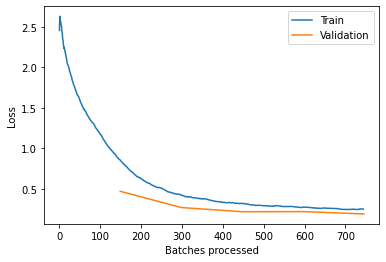

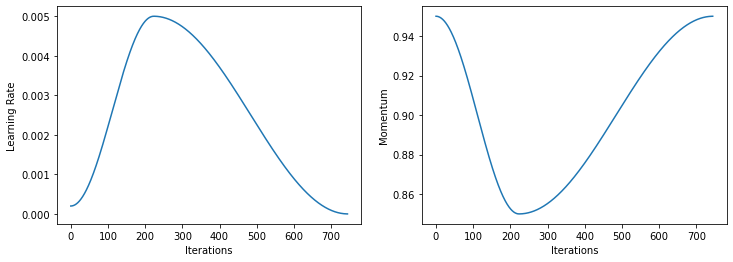

In [6]:
learn.fit_one_cycle(5, 0.005)
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)

In [7]:
learn.export('/home/jns2szh/code/res34-64_64_10_epoch.pkl')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

## visual check

In [10]:
from fastai.callbacks.hooks import *
from random import randint

# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImg,cl = imgDataBunch.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = imgDataBunch.one_item(tensorImg)
    oneBatch_im = vision.Image(imgDataBunch.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

In [ ]:
#interp = ClassificationInterpretation.from_learner(learn)
plot_heatmap_overview(interp, ['0','1','2','3'])

## incremental training

In [12]:
learn_tf = load_learner('/home/jns2szh/code/','b6-5-380-380-epoch.pkl')
data_tf = (ImageList.from_folder(data_path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(get_transforms(),size=224)    #Data augmentation? -> use tfms with a size of 64
        .databunch(path='.', bs=32, device= torch.device('cuda:7')))
learn_tf.data = data_tf

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.51E-04


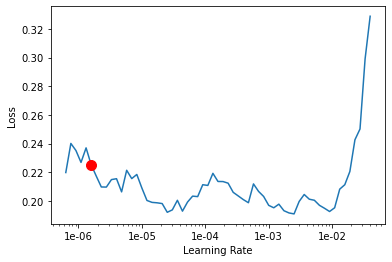

In [13]:
learn_tf.unfreeze()
learn_tf.lr_find()
learn_tf.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.102157,0.108727,0.965055,0.034945,05:03
1,0.083261,0.100071,0.964615,0.035385,05:01
2,0.079858,0.099732,0.965714,0.034286,05:03
3,0.073278,0.096308,0.967033,0.032967,05:03
4,0.062974,0.096095,0.965714,0.034286,05:03


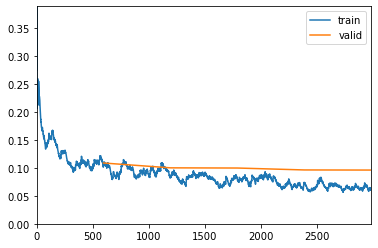

Better model found at epoch 0 with accuracy value: 0.9650549292564392.
Better model found at epoch 2 with accuracy value: 0.9657142758369446.
Better model found at epoch 3 with accuracy value: 0.9670329689979553.


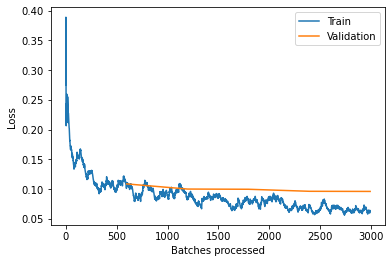

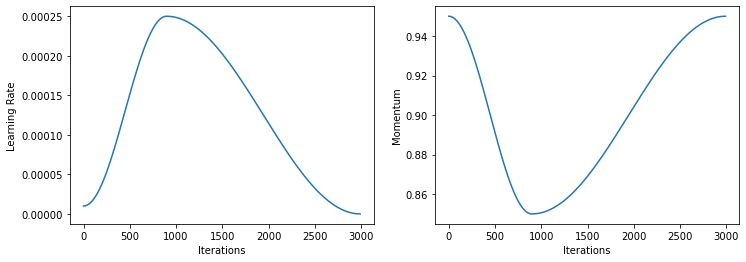

In [14]:
learn_tf.fit_one_cycle(5, 0.00025)
learn_tf.recorder.plot_losses()
learn_tf.recorder.plot_lr(show_moms=True)

In [6]:
learn_tf.export('/home/jns2szh/code/b6-5-224-224-epoch.pkl')
#interp = ClassificationInterpretation.from_learner(learn_tf)
#interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

## inference

In [9]:
#TTA and submission
# remove zoom from FastAI TTA
learn = load_learner('/home/jns2szh/code/','b6-5-380-380-epoch.pkl')
tta_params = {'beta':0.12, 'scale':1.0}
PATH = Path('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/')
sample_df = pd.read_csv('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/inference.csv')
learn.data.add_test(ImageList.from_df(
    sample_df, PATH
))

In [7]:
#preds,y = learn.TTA(ds_type=DatasetType.Test, **tta_params)
preds,y = learn.TTA(ds_type=DatasetType.Test)
#preds_processed = torch.softmax(preds, dim=1)[:, 1].numpy() #in case of forward is focal loss

In [11]:
from torch.nn import functional as F
#outputs = F.softmax(preds, dim=1)
#result = outputs.cuda().data.cpu().numpy()
result = preds.cuda().data.cpu().numpy()
print(len(result))
#result = preds.cuda().data.cpu().numpy()
dry = []
wet = []
snowy = []
na = []

for i in range(len(result)):
    dry.append(result[i][0])
    wet.append(result[i][1])
    snowy.append(result[i][2])
    na.append(result[i][3])
cont_list = {'dry':dry, 'wet':wet, 'snowy':snowy, 'na':na}
df = pd.DataFrame(cont_list, columns=['dry','wet','snowy','na'])
df.to_csv('result.csv')

16561


In [10]:
preds,y = learn.get_preds(ds_type=DatasetType.Test)